# Regression on the deer data

**Goal:** In this notebook you will work with TFP. You will set up different regression models that are able to output different conditional probability distribution. You will define all models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You compare the performace of all regression models on the test dataset.  


**Usage:** This notebook should be a case study that you can do by yourself. Try to solve the exercises and then look at the solution and compare your results.

**Dataset:** You work with a dataset that describes deer related car accidents in the years 2002 until 2011 on roads in Bavaria, Germany. It counts the number of deers killed during 30-minute periods anywhere in Bavaria. This dataset has been used previously for the analysis of count data in the statistics literature, and is originally from https://zenodo.org/record/17179. 

**Content:**
* Load and split the dataset 
* Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$
* Fit a poisson regression model in keras and TFP
* Fit a poisson regression model with hidden layers in keras and TFP
* Fit a zero-inflated poisson regression model im keras and TFP
* Fit a zero-inflated poisson regression model with hidden layers in keras and TFP
* Fit a mixture model regression model in keras and TFP
* Fit a mixture model regression model with hidden layers in keras and TFP
* Compare the different models based on the NLL loss on the test dataset

***Hint: Use the previous notebooks form this chapter and the one before as help and reference when you try to solve the exercises***  
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb)


In [2]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [1]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
# print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

In [4]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

#### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_probability as tfp
import os
from urllib.request import urlretrieve
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

TFP Version 0.8.0
TF  Version 2.0.0


### Loading and preprocessing of the data

In the next cells you download the dataset and install the feather-format library, if it is not already installed. The dataset already is splited in a train and test dataset. The trainset contains data from the year 2002 until 2010 and the testset contains data from 2010 until almost 2012. You do a bit of preprocessing by changing the categorical variables "daytime" and "weekday" into a dummy encoding, which is similar to the one hot encoding. You delete the information of the year and normalize the "time" variable to be in the range from 0 to 1. The target variable "wild" stands for the number of deers killed during that 30-minute period.

In [3]:
try:
    import feather
except:
    !pip install feather-format
    import feather

  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2462 sha256=3221ac319038aa8dccc2b9af27df3500d2fce99ef0cf8b7abb17b8ec1e26553d
  Stored in directory: c:\users\milind dalvi\appdata\local\pip\cache\wheels\6e\3d\05\ebe8270ca366aa12810ee508ed4fac30d6343ac1584523f9ac
Successfully built feather-format


In [4]:
def get_if_not_there(filename = 'deer_train.feather'):
    if not os.path.isfile(filename):
         urlretrieve('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/{}'.format(filename),
                    filename = filename)

get_if_not_there('deer_train.feather')
get_if_not_there('deer_test.feather')

In [5]:
df_train = feather.read_dataframe('deer_train.feather')
df_test = feather.read_dataframe('deer_test.feather')

In [6]:
df_train[0:2]

,wild,year,time,daytime,weekday
0,0,2002.0,0.000000,night.am,Sunday
1,0,2002.0,0.020833,night.am,Sunday


In [7]:
df_test[0:2]

,wild,year,time,daytime,weekday
0,0,2010.0,2922.000000,night.am,Sunday
1,2,2010.0,2922.020833,night.am,Sunday


In [8]:
print(df_train["daytime"].unique())
print(df_train["weekday"].unique())

[night.am, pre.sunrise.am, post.sunrise.am, day.am, day.pm, pre.sunset.pm, post.sunset.pm, night.pm]
Categories (8, object): [night.am, pre.sunrise.am, post.sunrise.am, day.am, day.pm, pre.sunset.pm, post.sunset.pm, night.pm]
[Sunday, Wednesday, Thursday, Friday, Saturday, Monday, Tuesday]
Categories (7, object): [Sunday, Wednesday, Thursday, Friday, Saturday, Monday, Tuesday]


In [9]:
y_train = df_train.iloc[:,0].to_numpy(dtype='float32')
y_test = df_test.iloc[:,0].to_numpy(dtype='float32')
X_train = pd.get_dummies(df_train.iloc[:,2:]) #We wont use the year
X_test = pd.get_dummies(df_test.iloc[:,2:])
X_train.iloc[:,0] = X_train.iloc[:,0]/2922.02    #We divide by the maximal number to be in the range 0 to 1
X_test.iloc[:,0] = X_test.iloc[:,0]/2922.02 
del df_train, df_test

In the next two cells you see how the two datasets look like after the preprocessing. You have around 140'000 observations in the train dataset and around 35'000 in the test dataset.

In [10]:
X_train[0:2]

,time,daytime_day.am,daytime_night.am,daytime_pre.sunrise.am,daytime_post.sunrise.am,daytime_day.pm,daytime_night.pm,daytime_pre.sunset.pm,daytime_post.sunset.pm,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday
0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.000007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
X_test[0:2]

,time,daytime_day.am,daytime_night.am,daytime_pre.sunrise.am,daytime_post.sunrise.am,daytime_day.pm,daytime_night.pm,daytime_pre.sunset.pm,daytime_post.sunset.pm,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday
0,0.999993,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
X_train = X_train.to_numpy(dtype='float32')
X_test = X_test.to_numpy(dtype='float32')

X_train.shape,X_test.shape

((140256, 16), (35040, 16))

Let's look at the distribution of the traget variable: the number of deers killed during that 30-minute period. As you can see the distribution is very skewed. Gor most of the time the nummber of deers killed by a car is, as you would expect, zero. On the other hand you can see that there were two 30-minute periods where 37 and 38 deers died! 

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 37. 38.]
[58184 31788 16339  9556  6367  4558  3274  2363  1766  1352  1079   870
   635   490   408   290   235   188   122   113    70    57    35    34
    23    23    11     7     6     4     3     3     1     1     1]


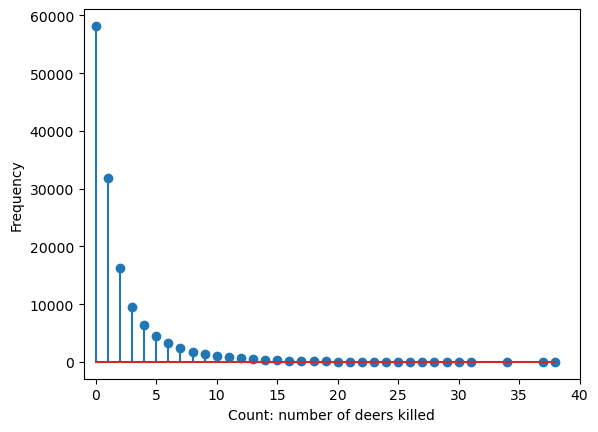

In [13]:
print(np.unique(y_train, return_counts=True)[0]) # all observed values
print(np.unique(y_train, return_counts=True)[1]) # the frequency of the observed values
vals, counts = np.unique(y_train, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.show()

### Fitting and comparing different regression models on count data

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*Exercise :     
Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$  
Fit a poisson regression model in keras and TFP  
Fit a poisson regression model with hidden layers in keras and TFP  
Fit a zero-inflated poisson regression model im keras and TFP  
Fit a zero-inflated poisson regression model with hidden layers in keras and TFP  
Fit a mixture model regression model in keras and TFP  
Fit a mixture model regression model with hidden layers in keras and TFP*  

*Compare the different models based on the NLL loss on the test dataset*

In [14]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

## Linear regression

In this section you do a standard linear regression in keras and optimize the mean squared error. Afterwards, you can claculate the optimal constant sigma by hand and compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period.

In [15]:
model_lr = Sequential() 
model_lr.add(Dense(1,input_dim=(X_train.shape[1]), activation='linear')) 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))
model_lr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [16]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 5s 33us/sample - loss: 6.6166 - val_loss: 8.3132
Epoch 2/10
140256/140256 [==============================] - 4s 30us/sample - loss: 6.5351 - val_loss: 8.3535
Epoch 3/10
140256/140256 [==============================] - 6s 40us/sample - loss: 6.5376 - val_loss: 8.3641
Epoch 4/10
140256/140256 [==============================] - 5s 39us/sample - loss: 6.5373 - val_loss: 8.3667
Epoch 5/10
140256/140256 [==============================] - 5s 35us/sample - loss: 6.5361 - val_loss: 8.4309
Epoch 6/10
140256/140256 [==============================] - 4s 31us/sample - loss: 6.5351 - val_loss: 8.3405
Epoch 7/10
140256/140256 [==============================] - 5s 39us/sample - loss: 6.5344 - val_loss: 8.3486
Epoch 8/10
140256/140256 [==============================] - 5s 35us/sample - loss: 6.5363 - val_loss: 8.3387
Epoch 9/10
140256/140256 [==============================] - 6s 40us/sample - 

6.544306916720569

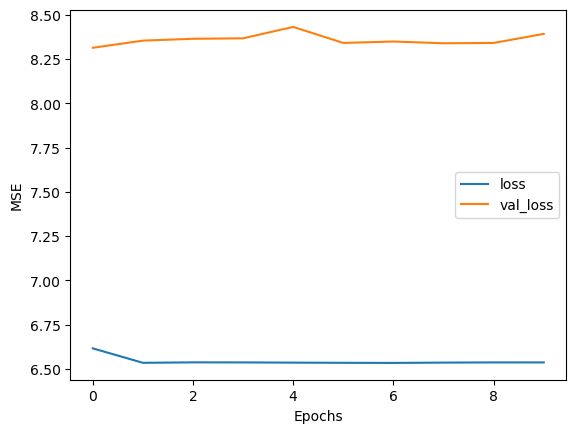

In [17]:
plt.plot(hist_lr.history['loss'])
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [18]:
# Calculation of the the optimal sigma 
n = len(y_train)
y_hat_train = model_lr.predict(X_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_lr.predict(X_test) #Prediction on the testset

NLL_lr =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)
print('NLL on test:',NLL_lr)

Estimated variance  6.537174104017417
Estimated standart deviation  2.5567898044261317
NLL on training: 2.357684867765519
NLL on test: 2.499529421677906


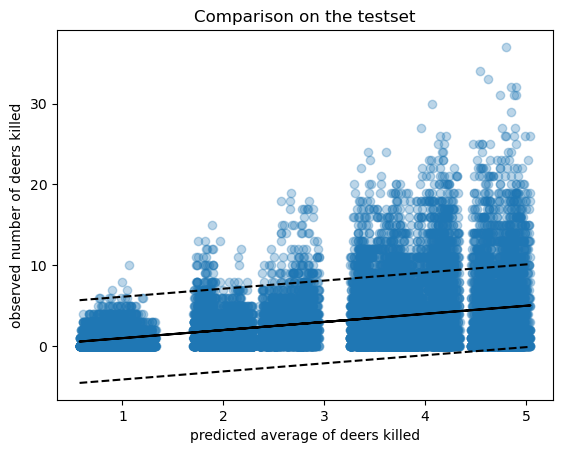

In [19]:

y_hat_test=model_lr.predict(X_test)
plt.scatter(y_hat_test, y_test,alpha=0.3)
sort_idx=np.argsort(y_hat_test,axis=0)
plt.plot(y_hat_test[sort_idx].flatten(), y_hat_test[sort_idx].flatten()+2*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(y_hat_test[sort_idx].flatten(), y_hat_test[sort_idx].flatten()-2*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()

## Poisson Regression

In this section you do a poisson regression with keras and TFP and optimize the NLL. Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. Note that a poisson regression is better suited than a linear regression because we are dealing with count data in this problem.

In [20]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, activation=tf.exp)(inputs) 
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model_p = Model(inputs=inputs, outputs=p_y) 

def NLL(y_true, y_hat): 
    return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 5s 38us/sample - loss: 1.9343 - val_loss: 2.0800
Epoch 2/10
140256/140256 [==============================] - 5s 35us/sample - loss: 1.9186 - val_loss: 2.0824
Epoch 3/10
140256/140256 [==============================] - 5s 35us/sample - loss: 1.9185 - val_loss: 2.0742
Epoch 4/10
140256/140256 [==============================] - 5s 36us/sample - loss: 1.9193 - val_loss: 2.1166
Epoch 5/10
140256/140256 [==============================] - 5s 35us/sample - loss: 1.9186 - val_loss: 2.1647
Epoch 6/10
140256/140256 [==============================] - 5s 36us/sample - loss: 1.9188 - val_loss: 2.0823
Epoch 7/10
140256/140256 [==============================] - 5s 36us/sample - loss: 1.9187 - val_loss: 2.0756
Epoch 8/10
140256/140256 [==============================] - 5s 35us/sample - loss: 1.9190 - val_loss: 2.0702
Epoch 9/10
140256/140256 [==============================] - 5s 35us/sample - 

Text(0.5, 0, 'Epochs')

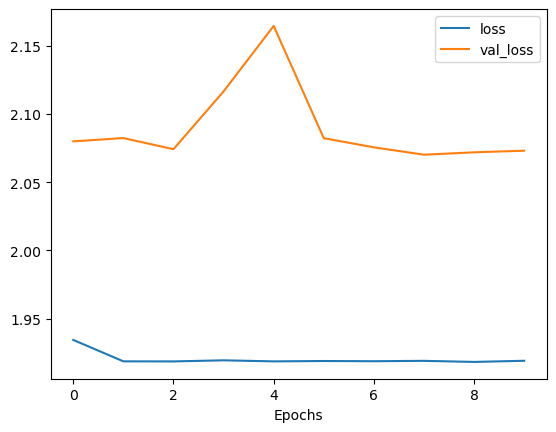

In [22]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [23]:
model = Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_p.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_p.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.9217168750649796
NLL on test: 2.073145489714461


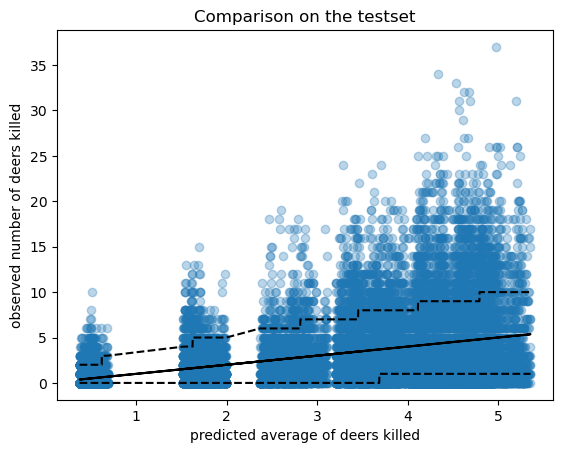

In [24]:
from scipy.stats import poisson
lower=poisson.ppf(0.025, y_hat_test)
upper=poisson.ppf(0.975, y_hat_test)

plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()

## Poisson Regression with hidden layers

In this section you do a poisson regression with keras and TFP and optimize the NLL. This time we add some hidden layers in between. Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. Note that a poisson regression is better suited than a linear regression because we are dealing with count data in this problem.

In [25]:
inputs = Input(shape=(X_train.shape[1],))  
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
rate = Dense(1, activation=tf.exp)(x) 
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model_p = Model(inputs=inputs, outputs=p_y) 

def NLL(y_true, y_hat): 
    return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 12,821
Trainable params: 12,821
Non-trainable params: 0
_______________________________________________________

In [26]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 8s 55us/sample - loss: 1.9099 - val_loss: 2.0635
Epoch 2/10
140256/140256 [==============================] - 7s 50us/sample - loss: 1.8949 - val_loss: 2.0817
Epoch 3/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.8918 - val_loss: 2.0458
Epoch 4/10
140256/140256 [==============================] - 8s 56us/sample - loss: 1.8905 - val_loss: 2.0577
Epoch 5/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.8903 - val_loss: 2.0611
Epoch 6/10
140256/140256 [==============================] - 7s 53us/sample - loss: 1.8910 - val_loss: 2.0412
Epoch 7/10
140256/140256 [==============================] - 8s 60us/sample - loss: 1.8901 - val_loss: 2.0553
Epoch 8/10
140256/140256 [==============================] - 8s 57us/sample - loss: 1.8898 - val_loss: 2.0357
Epoch 9/10
140256/140256 [==============================] - 8s 56us/sample - 

Text(0.5, 0, 'Epochs')

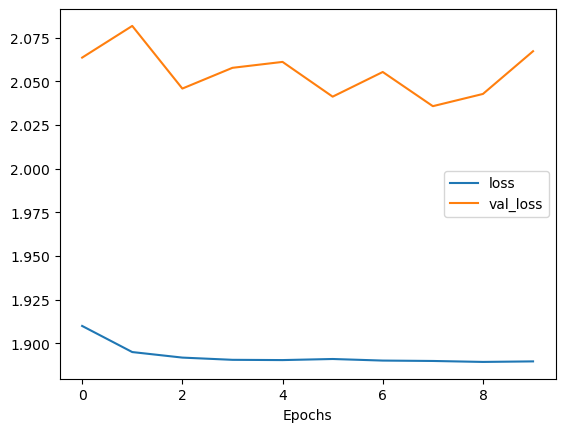

In [27]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [28]:
model = Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_p.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_p.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.8824493953987476
NLL on test: 2.0672012059111573


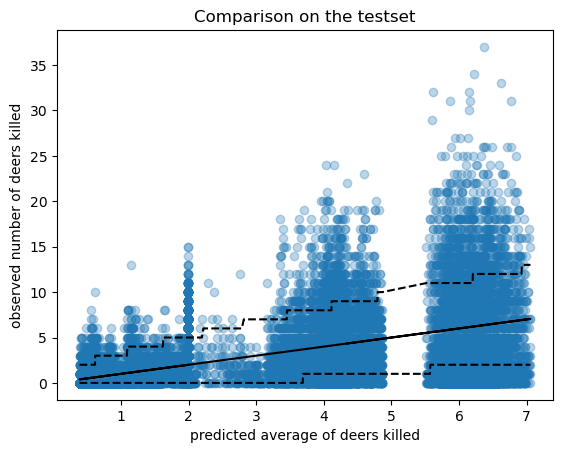

In [29]:
from scipy.stats import poisson
lower=poisson.ppf(0.025, y_hat_test)
upper=poisson.ppf(0.975, y_hat_test)

plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()

## Zero inflated Poisson Regression

In this section you do a zero infalted poisson regression with keras and TFP and optimize the NLL. A zero inflated poisson regression should be better suited because for most of the time the number of killed deer in a 30-minutes period is zero. You define ZIP distribution in TFP with the two parameters :
* rate: which defines the rate $\lambda$ of a Poisson process
* s: the probability to pick Poisson process (accordingly the zero-generating process is picked with probability 1-s)

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [30]:
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0. We use the squeeze function to flatten the tensor.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [31]:

## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs)#A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

#A A dense layer is used without activation. The transformation is done inside zero_inf function

model_zi.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
_________________________________________________________________
distribution_lambda_2 (Distr ((None,), (None,))        0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [32]:
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 6s 44us/sample - loss: 1.8076 - val_loss: 1.9304
Epoch 2/10
140256/140256 [==============================] - 6s 39us/sample - loss: 1.7972 - val_loss: 1.9347
Epoch 3/10
140256/140256 [==============================] - 6s 40us/sample - loss: 1.7970 - val_loss: 1.9474
Epoch 4/10
140256/140256 [==============================] - 6s 39us/sample - loss: 1.7977 - val_loss: 1.9574
Epoch 5/10
140256/140256 [==============================] - 6s 40us/sample - loss: 1.7971 - val_loss: 1.9597
Epoch 6/10
140256/140256 [==============================] - 6s 40us/sample - loss: 1.7965 - val_loss: 1.9310
Epoch 7/10
140256/140256 [==============================] - 6s 40us/sample - loss: 1.7973 - val_loss: 1.9374
Epoch 8/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.7967 - val_loss: 1.9367
Epoch 9/10
140256/140256 [==============================] - 6s 40us/sample - 

Text(0.5, 0, 'Epochs')

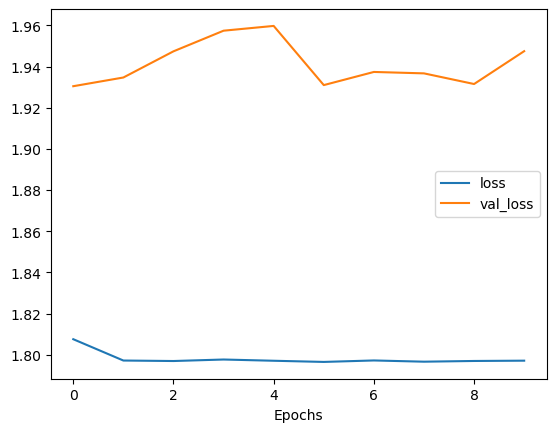

In [33]:
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [34]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_zi.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_zi.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.794957752630859
NLL on test: 1.9474539940760016


In [35]:
# workaround; only sample from 10 datapoints at once, otherwise we would get ram errors
upper=[]
lower=[]
for i in tqdm(range(0,np.int(len(X_test)/10))):
    samples_tmp=model_zi(X_test[(i*10):(i*10)+10]).sample(5000).numpy()
    upper=np.append(upper,np.quantile(samples_tmp,0.975,axis=0))
    lower=np.append(lower,np.quantile(samples_tmp,0.025,axis=0))

e:\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


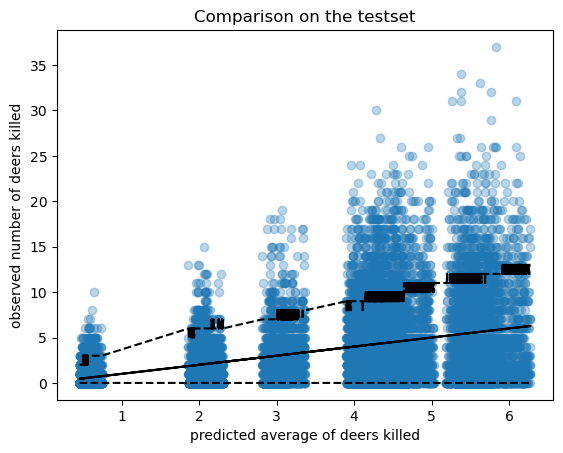

In [36]:
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()

## Zero inflated Poisson Regression with hidden layers

In this section you do a zero infalted poisson regression with keras and TFP and optimize the NLL. A zero inflated poisson regression should be better suited because for most of the time the number of killed deer in a 30-minutes period is zero. This time you also add some hidden layers in between. You define ZIP distribution in TFP with the two parameters :
* the probability 1-p with which zeros are produced
* the rate of a Poisson distribution with probability p.

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [37]:
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0. We use the squeeze function to flatten the tensor.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [38]:

## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
out = Dense(2)(x)#A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

#A A dense layer is used without activation. The transformation is done inside zero_inf function

model_zi.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 22        
_________________________________________________________________
distribution_lambda_3 (Distr ((None,), (None,))        0         
Total params: 12,832
Trainable params: 12,832
Non-trainable params: 0
_______________________________________________________

In [39]:
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 8s 54us/sample - loss: 1.7963 - val_loss: 1.9177
Epoch 2/10
140256/140256 [==============================] - 7s 48us/sample - loss: 1.7845 - val_loss: 1.9154
Epoch 3/10
140256/140256 [==============================] - 7s 48us/sample - loss: 1.7851 - val_loss: 1.9132
Epoch 4/10
140256/140256 [==============================] - 7s 48us/sample - loss: 1.7816 - val_loss: 1.9296
Epoch 5/10
140256/140256 [==============================] - 7s 49us/sample - loss: 1.7817 - val_loss: 1.9085
Epoch 6/10
140256/140256 [==============================] - 7s 49us/sample - loss: 1.7815 - val_loss: 1.9188
Epoch 7/10
140256/140256 [==============================] - 7s 48us/sample - loss: 1.7810 - val_loss: 1.9254
Epoch 8/10
140256/140256 [==============================] - 7s 49us/sample - loss: 1.7819 - val_loss: 1.9102
Epoch 9/10
140256/140256 [==============================] - 7s 48us/sample - 

Text(0.5, 0, 'Epochs')

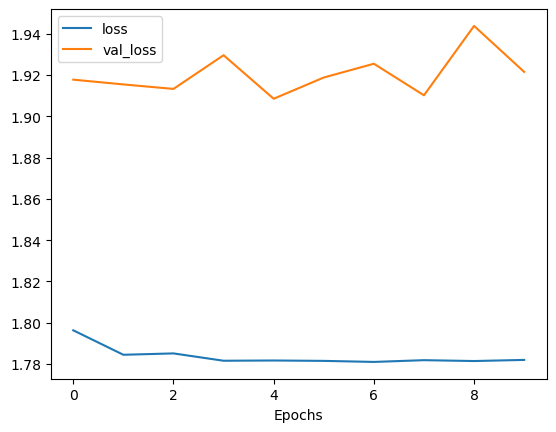

In [40]:
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [41]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_zi.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_zi.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.7777207850893149
NLL on test: 1.9214857947336483


In [42]:
# workaround; only sample from 10 datapoints at once, otherwise we would get ram errors
upper=[]
lower=[]
for i in tqdm(range(0,np.int(len(X_test)/10))):
    samples_tmp=model_zi(X_test[(i*10):(i*10)+10]).sample(5000).numpy()
    upper=np.append(upper,np.quantile(samples_tmp,0.975,axis=0))
    lower=np.append(lower,np.quantile(samples_tmp,0.025,axis=0))


e:\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


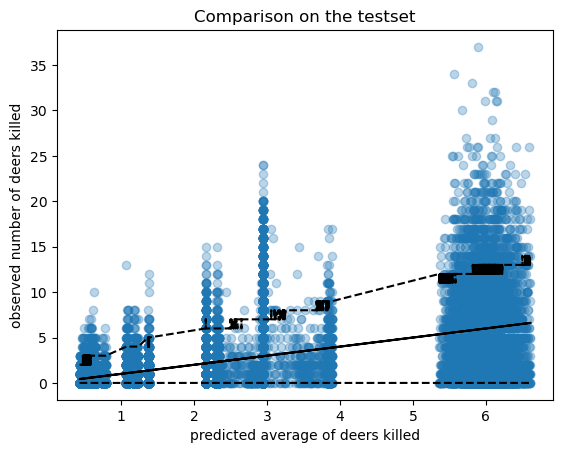

In [43]:
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()

## Regression with a discretized logistic mixture distribution

In this section you do a regression with a discretized logistic mixture distribution in keras and TFP and optimize the NLL.  
Fist you define the quant_mixture_logistic function and then you can use it with the tfp.layers.DistributionLambda layer as the output for your model.  
See aslo: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution. For each mixture component the NN needs to estimate three parameters: The location of the component, the spread and how much the component is weighted. Note that the output should be without activation (as it is default in Keras).

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [45]:
np.unique(y_train)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 34., 37., 38.], dtype=float32)

In [46]:
2**8 - 1.

255.0

In [54]:
def quant_mixture_logistic(out, bits=8, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=38)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [55]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(9)(inputs)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

model = Model(inputs=inputs, outputs=p_y)

def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 153       
_________________________________________________________________
distribution_lambda_5 (Distr ((None,), (None,))        0         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [56]:
hist_mm = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 7s 49us/sample - loss: 1.6273 - val_loss: 1.7117
Epoch 2/10
140256/140256 [==============================] - 6s 43us/sample - loss: 1.6162 - val_loss: 1.7024
Epoch 3/10
140256/140256 [==============================] - 6s 43us/sample - loss: 1.6154 - val_loss: 1.7130
Epoch 4/10
140256/140256 [==============================] - 6s 44us/sample - loss: 1.6155 - val_loss: 1.7124
Epoch 5/10
140256/140256 [==============================] - 6s 43us/sample - loss: 1.6154 - val_loss: 1.7055
Epoch 6/10
140256/140256 [==============================] - 6s 44us/sample - loss: 1.6152 - val_loss: 1.7041
Epoch 7/10
140256/140256 [==============================] - 6s 45us/sample - loss: 1.6151 - val_loss: 1.7167
Epoch 8/10
140256/140256 [==============================] - 6s 45us/sample - loss: 1.6153 - val_loss: 1.7018
Epoch 9/10
140256/140256 [==============================] - 6s 45us/sample - 

Text(0.5, 0, 'Epochs')

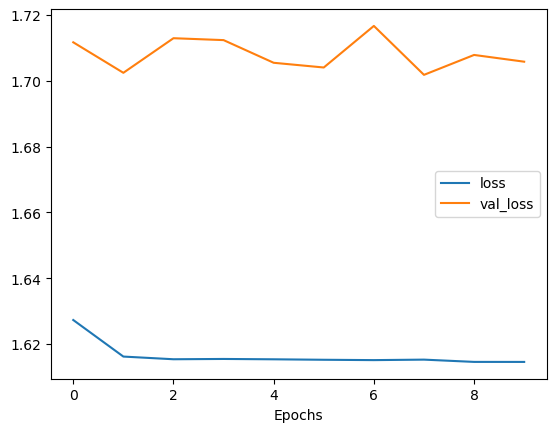

In [57]:
plt.plot(hist_mm.history['loss'])
plt.plot(hist_mm.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [58]:
print(-np.mean(model(X_train).log_prob(y_train)))
print(-np.mean(model(X_test).log_prob(y_test)))

1.6145571
1.7058197


Note that there is no mean function for the QuantizedDistribution, therefore we sample for 1000 times and then take the mean of this 1000 samples.



In [59]:
NLL_train = model.evaluate(X_train, y_train,verbose=0) 
NLL_test = model.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

preds = np.zeros((1000,len(y_test.flatten())))
for i in tqdm(range(0,1000)):
    preds[i,:] = model(X_test).sample().numpy()# sample from the QuantizedDistribution
y_hat_test=np.average(preds,axis=0)


NLL on training: 1.6145570788540144
NLL on test: 1.7058196925681475


e:\Miniconda3\lib\site-packages\ipykernel\__main__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [60]:
# workaround; only sample from 10 datapoints at once, otherwise we would get ram errors
upper=[]
lower=[]
for i in tqdm(range(0,np.int(len(X_test)/10))):
    samples_tmp=model(X_test[(i*10):(i*10)+10]).sample(5000).numpy()
    upper=np.append(upper,np.quantile(samples_tmp,0.975,axis=0))
    lower=np.append(lower,np.quantile(samples_tmp,0.025,axis=0))


e:\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


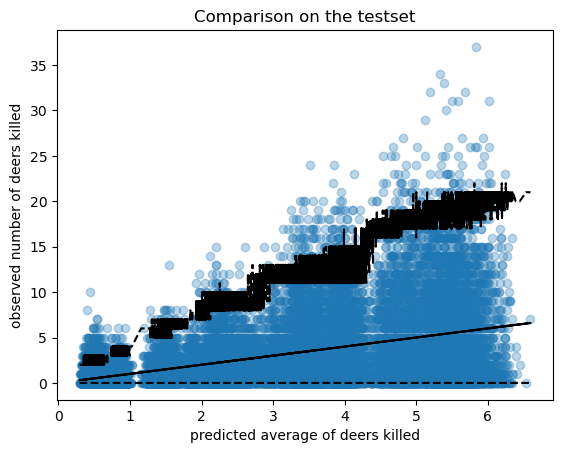

In [61]:
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()

## Regression with a discretized logistic mixture distribution and hidden layers

In this section you do a regression with a discretized logistic mixture distribution in keras and TFP and optimize the NLL. This time you will add some hidden layers in between.  
Fist you define the quant_mixture_logistic function and then you can use it with the tfp.layers.DistributionLambda layer as the output for your model.  
See aslo: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution. For each mixture component the NN needs to estimate three parameters: The location of the component, the spread and how much the component is weighted. Note that the output should be without activation (as it is default in Keras).

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [62]:
def quant_mixture_logistic(out, bits=8, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=38)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [63]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
out = Dense(9)(x)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

model = Model(inputs=inputs, outputs=p_y)

def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 99        
_________________________________________________________________
distribution_lambda_6 (Distr ((None,), (None,))        0         
Total params: 12,909
Trainable params: 12,909
Non-trainable params: 0
______________________________________________________

In [64]:
hist_mm = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 8s 59us/sample - loss: 1.6230 - val_loss: 1.7051
Epoch 2/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.6171 - val_loss: 1.7048
Epoch 3/10
140256/140256 [==============================] - 7s 52us/sample - loss: 1.6179 - val_loss: 1.7014
Epoch 4/10
140256/140256 [==============================] - 8s 54us/sample - loss: 1.6148 - val_loss: 1.7052
Epoch 5/10
140256/140256 [==============================] - 8s 54us/sample - loss: 1.6159 - val_loss: 1.7061
Epoch 6/10
140256/140256 [==============================] - 8s 55us/sample - loss: 1.6150 - val_loss: 1.7016
Epoch 7/10
140256/140256 [==============================] - 8s 55us/sample - loss: 1.6168 - val_loss: 1.7046
Epoch 8/10
140256/140256 [==============================] - 7s 53us/sample - loss: 1.6150 - val_loss: 1.7011
Epoch 9/10
140256/140256 [==============================] - 8s 53us/sample - 

Text(0.5, 0, 'Epochs')

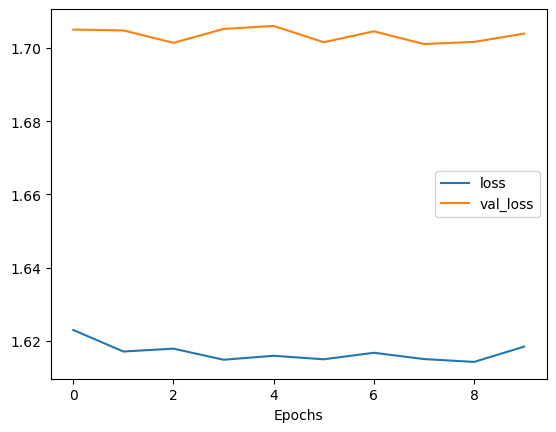

In [65]:
plt.plot(hist_mm.history['loss'])
plt.plot(hist_mm.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [66]:
print(-np.mean(model(X_train).log_prob(y_train)))
print(-np.mean(model(X_test).log_prob(y_test)))

1.6150651
1.703956


Note that there is no mean function for the QuantizedDistribution, therefore we sample for 1000 times and then take the mean of this 1000 samples.


In [67]:
NLL_train = model.evaluate(X_train, y_train,verbose=0) 
NLL_test = model.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

preds = np.zeros((1000,len(y_test.flatten())))
for i in tqdm(range(0,1000)):
    preds[i,:] = model(X_test).sample().numpy()# sample from the QuantizedDistributio
y_hat_test=np.average(preds,axis=0)


NLL on training: 1.6150652028751133
NLL on test: 1.7039560369160622


e:\Miniconda3\lib\site-packages\ipykernel\__main__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [99]:
# workaround; only sample from 10 datapoints at once, otherwise we would get ram errors
upper=[]
lower=[]
for i in tqdm(range(0,np.int(len(X_test)/10))):
    samples_tmp=model(X_test[(i*10):(i*10)+10]).sample(5000).numpy()
    upper=np.append(upper,np.quantile(samples_tmp,0.975,axis=0))
    lower=np.append(lower,np.quantile(samples_tmp,0.025,axis=0))


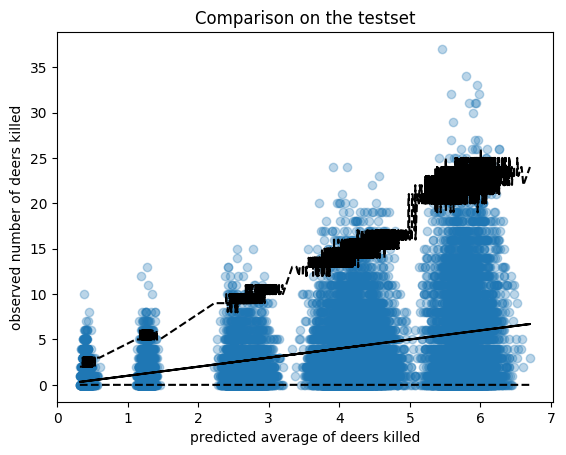

In [100]:
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of deers killed')
plt.ylabel('observed number of deers killed')
plt.show()